# Analiza rozkładów opóźnień

### importy

In [2]:
import pandas as pd
import numpy as np
import scipy
from scipy import stats
import matplotlib.pyplot as plt
import os

In [3]:
# directory = "../dane/gtfs-drive/"
directory = "../data/gtfsy/"
day = '2023-06-15'

In [4]:
import re

In [7]:
os.listdir(directory)

['2022-03-22.gtfs',
 '2022-03-23.gtfs',
 '2022-03-24.gtfs',
 '2022-03-29-rt.gtfs',
 '2022-03-29.gtfs',
 '2022-03-30-rt.gtfs',
 '2022-03-30.gtfs',
 '2022-03-31-rt.gtfs',
 '2022-03-31.gtfs',
 '2022-04-05-rt.gtfs',
 '2022-04-05.gtfs',
 '2022-04-06-rt.gtfs',
 '2022-04-06.gtfs',
 '2022-04-07-rt.gtfs',
 '2022-04-07.gtfs',
 '2022-04-12-rt.gtfs',
 '2022-04-12.gtfs',
 '2022-04-13-rt.gtfs',
 '2022-04-13.gtfs',
 '2022-04-14-rt.gtfs',
 '2022-04-14.gtfs',
 '2022-04-19-rt.gtfs',
 '2022-04-19.gtfs',
 '2022-04-20-rt.gtfs',
 '2022-04-20.gtfs',
 '2022-04-21-rt.gtfs',
 '2022-04-21.gtfs',
 '2022-04-24-rt.gtfs',
 '2022-04-25-rt.gtfs',
 '2022-04-25.gtfs',
 '2022-04-26-rt.gtfs',
 '2022-04-26.gtfs',
 '2022-04-27-rt.gtfs',
 '2022-04-27.gtfs',
 '2022-04-28-rt.gtfs',
 '2022-04-28.gtfs',
 '2022-05-10-rt.gtfs',
 '2022-05-10.gtfs',
 '2022-05-11-rt.gtfs',
 '2022-05-11.gtfs',
 '2022-05-12-rt.gtfs',
 '2022-05-12.gtfs',
 '2022-05-17-rt.gtfs',
 '2022-05-17.gtfs',
 '2022-05-18.gtfs',
 '2022-05-19-rt.gtfs',
 '2022-05-19.g

### odfiltrowanie dat z dostępnymi plikami gtfs rozkładowymi oraz realtime

In [8]:
# filtrowanie dat z plikami rozkładowymi i realtime
dates = []
for i in  range(len(os.listdir(directory))-1):
    f = os.listdir(directory)[i]
    if f[11:13] == "rt":
        f2 = os.listdir(directory)[i+1]
        if f2[11:13] != "rt" and f[0:10] == f2[0:10]:
            dates.append(f[0:10])
            i = i+1


In [9]:
dates

['2022-03-29',
 '2022-03-30',
 '2022-03-31',
 '2022-04-05',
 '2022-04-06',
 '2022-04-07',
 '2022-04-12',
 '2022-04-13',
 '2022-04-14',
 '2022-04-19',
 '2022-04-20',
 '2022-04-21',
 '2022-04-25',
 '2022-04-26',
 '2022-04-27',
 '2022-04-28',
 '2022-05-10',
 '2022-05-11',
 '2022-05-12',
 '2022-05-17',
 '2022-05-19',
 '2022-05-24',
 '2022-05-25',
 '2022-05-26',
 '2022-05-28',
 '2022-05-31',
 '2022-06-01',
 '2022-06-02',
 '2022-06-07',
 '2022-06-08',
 '2022-06-09',
 '2022-06-14',
 '2022-06-15',
 '2022-06-16',
 '2022-06-21',
 '2022-06-22',
 '2022-06-23',
 '2022-09-01',
 '2022-09-02',
 '2022-09-03',
 '2022-11-15',
 '2022-11-16',
 '2022-11-17',
 '2022-11-22',
 '2022-11-23',
 '2022-11-24',
 '2022-11-29',
 '2022-11-30',
 '2022-12-01',
 '2022-12-06',
 '2022-12-07',
 '2022-12-08',
 '2022-12-12',
 '2022-12-13',
 '2022-12-14',
 '2022-12-15',
 '2023-04-25',
 '2023-04-26',
 '2023-04-27',
 '2023-05-02',
 '2023-05-09',
 '2023-05-10',
 '2023-05-11',
 '2023-05-16',
 '2023-05-17',
 '2023-05-18',
 '2023-05-

### kody ładowania danych i plotowania

In [9]:
def get_df(directory, day):
    filepath = directory + day
    extension = ".gtfs"
    routes_df = pd.read_csv(filepath + extension + "/routes.txt")
    stop_times_df = pd.read_csv(filepath + extension + "/stop_times.txt")
    trips_df = pd.read_csv(filepath + extension + "/trips.txt")
    rt_stop_times_df = pd.read_csv(filepath + '-rt.gtfs/stop_times.txt')
    merged_df = stop_times_df.merge(trips_df, on = 'trip_id').merge(routes_df, on = 'route_id').merge(rt_stop_times_df, on=['trip_id', 'stop_id'])
    merged_df['arrival_time_x'] = merged_df['arrival_time_x'].str.strip()
    merged_df['arrival_time_y'] = merged_df['arrival_time_y'].str.strip()
    

    # Create the past_midnight column

    merged_df['diff'] = pd.to_timedelta(merged_df['departure_time_y'], errors='coerce') - pd.to_timedelta(merged_df['departure_time_x'], errors='coerce')
    merged_df['diff'] = merged_df['diff'].apply(lambda x: pd.Timedelta.total_seconds(x))
    merged_df = merged_df[["route_short_name", "diff"]]
    merged_df['route_short_name'] = merged_df['route_short_name'].str.strip()

    lower_quantile = merged_df['diff'].quantile(0.025)
    upper_quantile = merged_df['diff'].quantile(0.975)
    # Filter the dataframe to keep values within the 2.5% - 97.5% range
    filtered_df = merged_df[(merged_df['diff'] >= lower_quantile) & (merged_df['diff'] <= upper_quantile)]
    return filtered_df

In [11]:
from matplotlib import colors

In [12]:
cdict = {'red':   ((0.0,  0.22, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.89, 1.0)),

         'green': ((0.0,  0.49, 0.0),
                   (0.5,  1.0, 1.0),
                   (1.0,  0.12, 1.0)),

         'blue':  ((0.0,  0.72, 0.0),
                   (0.5,  0.0, 0.0),
                   (1.0,  0.11, 1.0))}

cmap = plt.cm.Blues(np.linspace(0,1)) # kolory zmieniajace sie w zaleznosci od daty
cmap = colors.ListedColormap(cmap[10:,:-1])

#cmap = colors.LinearSegmentedColormap('custom', cdict)

In [13]:
# plot dystrybuant empirycznych danej lini z podzialem na daty
def plot_ecdfs(dfs, line):
    ecdfs = []
    for df in dfs:
        sample = df.loc[df['route_short_name'] == line]['diff']
        if len(sample)==0: continue
        ecdfs.append(stats.ecdf(sample))
    i = 0
    n = len(ecdfs)
    for ecdf in ecdfs:
        ecdf.cdf.plot(label = f'{i}',color = cmap(i/n))
        i = i + 1
    plt.title(f'Empiryczne funkcje dystrybuanty opóźnień [s], linia: {line}')
    #plt.legend()

### Załadowanie danych z wszystkich dostępnych dni

In [14]:
dfs = []
for date in dates:
    dfs.append(get_df(directory, date))

In [27]:
routes_df = pd.read_csv("../data/gtfsy/2022-05-19.gtfs/routes.txt")
route_type_dict = routes_df[["route_short_name","route_type"]].set_index('route_short_name').to_dict()['route_type']

### Przykładowe wykresy

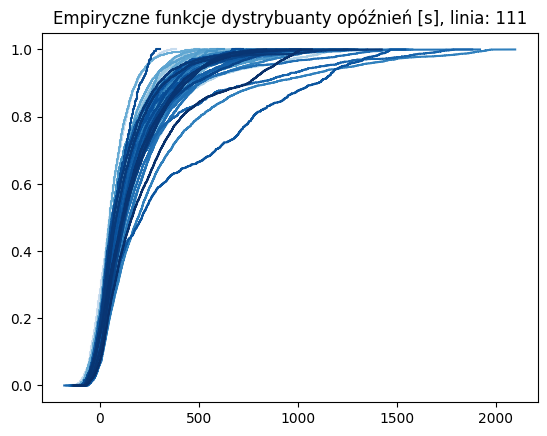

In [15]:
plot_ecdfs(dfs, "111")

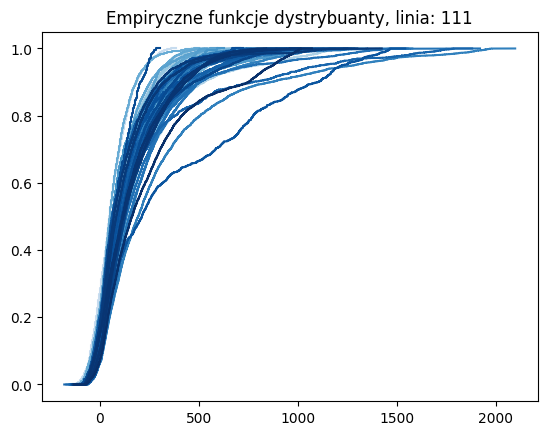

In [148]:
plot_ecdfs(dfs, "111")

In [19]:
a = [len(x.route_short_name.unique()) for x in dfs]

In [20]:
index_max = a.index(max(a))
index_max

20

In [21]:
lista_linii = dfs[index_max].route_short_name.unique()

In [22]:
lista_linii

array(['1', '10', '102', '103', '104', '105', '106', '107', '108', '109',
       '11', '110', '111', '112', '114', '115', '116', '117', '118',
       '119', '120', '121', '122', '123', '124', '125', '126', '127',
       '128', '129', '13', '130', '131', '132', '133', '134', '135',
       '136', '138', '139', '14', '140', '141', '142', '143', '145',
       '146', '147', '148', '149', '15', '150', '151', '152', '153',
       '154', '156', '157', '158', '159', '160', '161', '162', '163',
       '164', '165', '166', '167', '168', '169', '17', '170', '171',
       '172', '173', '174', '175', '176', '177', '178', '179', '18',
       '180', '181', '182', '183', '184', '185', '186', '187', '188',
       '189', '190', '191', '192', '193', '194', '195', '196', '197',
       '198', '199', '2', '20', '200', '201', '202', '203', '204', '206',
       '207', '208', '209', '210', '211', '212', '213', '217', '218',
       '219', '22', '220', '221', '222', '225', '228', '23', '234', '239',
       '24', 

### stworzenie tabeli z wynikami testów kruskala-wallisa

In [23]:
# stworzenie tabeli z wynikami testu kruskala-wallisa
h_stat = []
p_val = []
for line in lista_linii:
    samples = []
    for df in dfs:
        sample = df.loc[df['route_short_name'] == line]['diff']
        if len(sample)==0: continue
        samples.append(sample)
    kruskal = stats.kruskal(*samples)
    h_stat.append(kruskal.statistic)
    p_val.append(kruskal.pvalue)

In [30]:
kruskal_df = pd.DataFrame({"line":lista_linii, "h_stat":np.array(h_stat), "p-val":np.array(p_val)})

In [31]:
kruskal_df.loc[[route_type_dict[x]==0 for x in kruskal_df.line]].sort_values(by="h_stat", ascending=True).head()

,line,h_stat,p-val
1,10,1998.122901,0.0
81,18,2003.516967,0.0
40,14,2026.012289,0.0
173,41,2512.929557,0.0
10,11,4058.433789,0.0


In [36]:
kruskal_df.loc[[route_type_dict[x]==3 for x in kruskal_df.line]].sort_values(by="h_stat", ascending=False).set_index("line")[0:9]

,h_stat,p-val
line,,
116,45971.086436,0.0
189,44909.125500,0.0
167,38721.127737,0.0
112,38692.560299,0.0
180,30957.903939,0.0
187,29847.033772,0.0
141,25421.194861,0.0
523,24879.156990,0.0
136,23240.303087,0.0


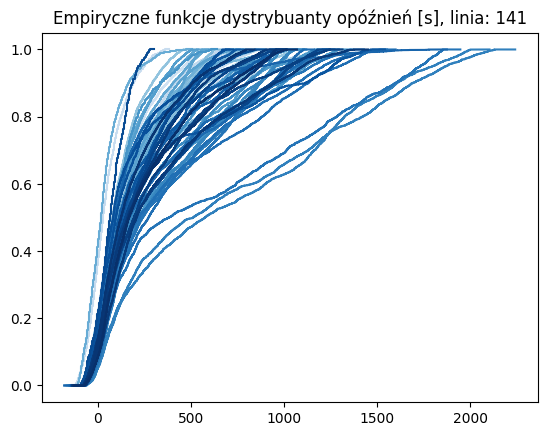

In [37]:
plot_ecdfs(dfs, "141")

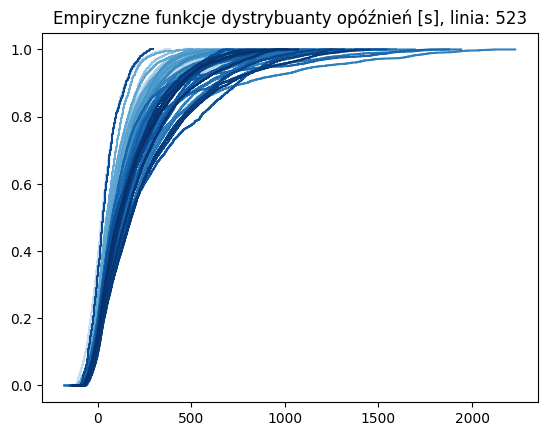

In [38]:
plot_ecdfs(dfs, "523")

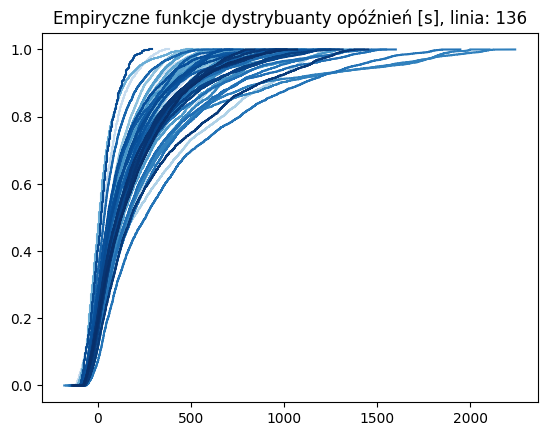

In [39]:
plot_ecdfs(dfs, "136")

In [244]:
kruskal_df.loc[[route_type_dict[x]==0 for x in kruskal_df.line]].sort_values(by="h_stat", ascending=False).head(6).set_index("line").to_clipboard()

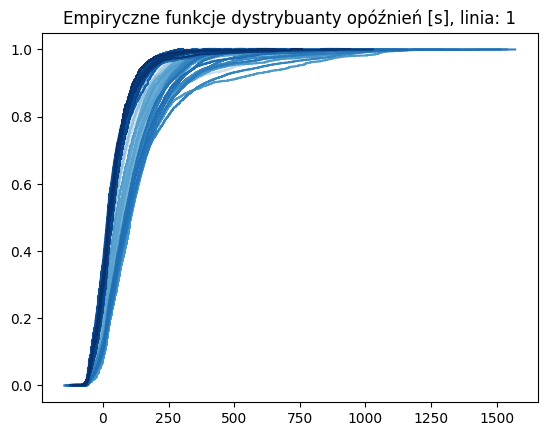

In [238]:
plot_ecdfs(dfs, "1")

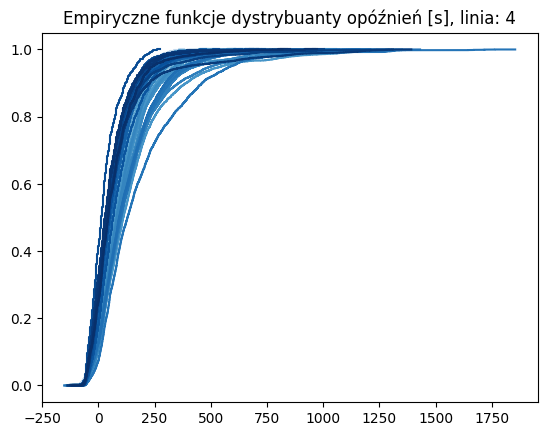

In [239]:
plot_ecdfs(dfs, "4")

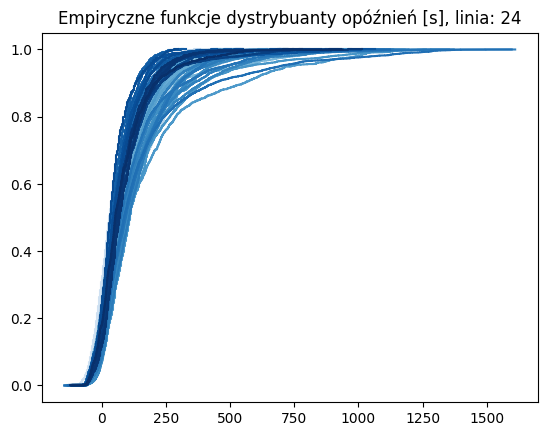

In [240]:
plot_ecdfs(dfs, "24")

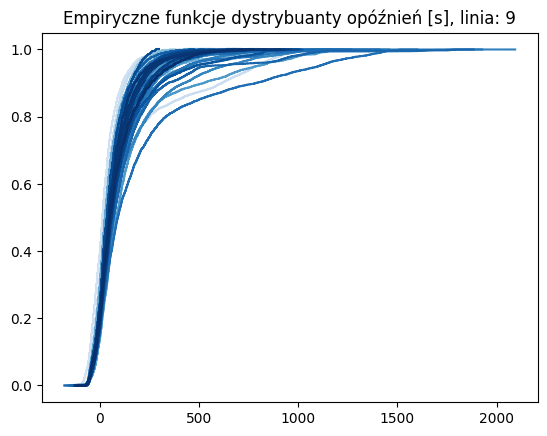

In [241]:
plot_ecdfs(dfs, "9")

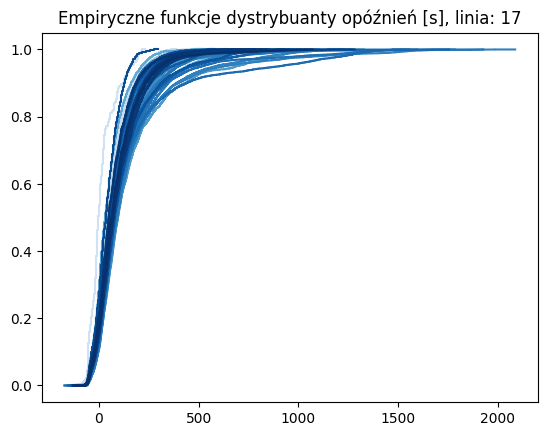

In [242]:
plot_ecdfs(dfs, "17")

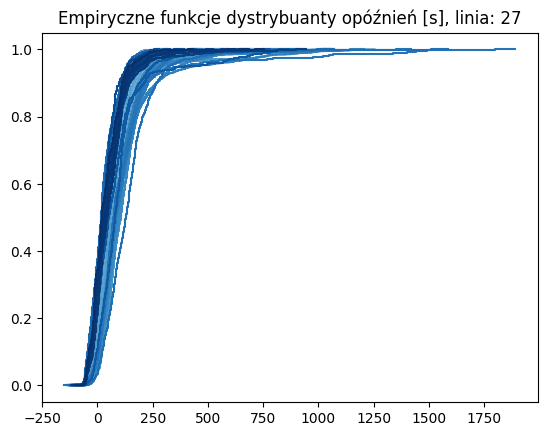

In [243]:
plot_ecdfs(dfs, "27")

In [112]:
kruskal_df.loc[[route_type_dict[x]==3 for x in kruskal_df.line]].sort_values(by="h_stat", ascending=True).tail().set_index("line").to_clipboard()

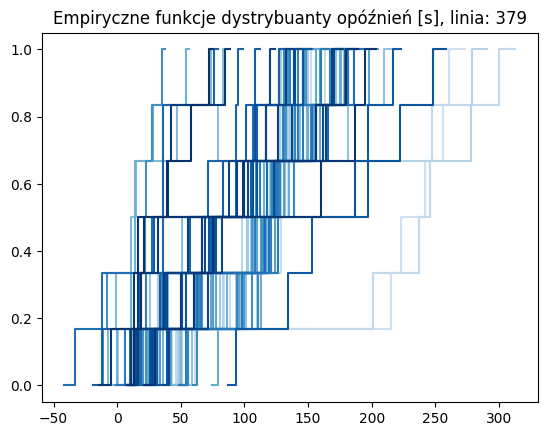

In [16]:
plot_ecdfs(dfs, "379")

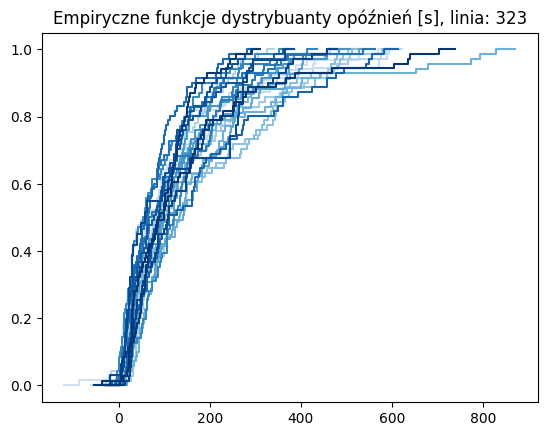

In [164]:
plot_ecdfs(dfs, "323")

In [28]:
df = dfs[7]
df.loc[df["route_short_name"]=="N62"].shape
#df.shape

(10, 2)

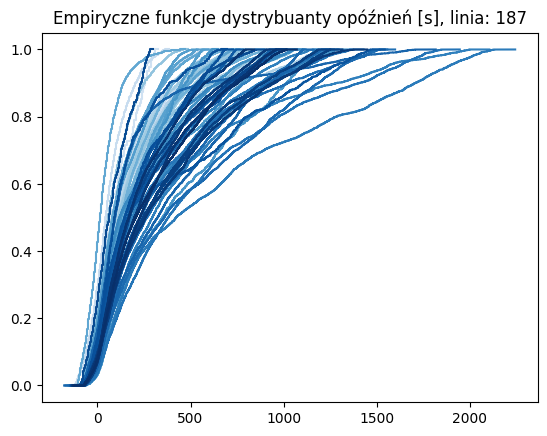

In [165]:
plot_ecdfs(dfs, "187")

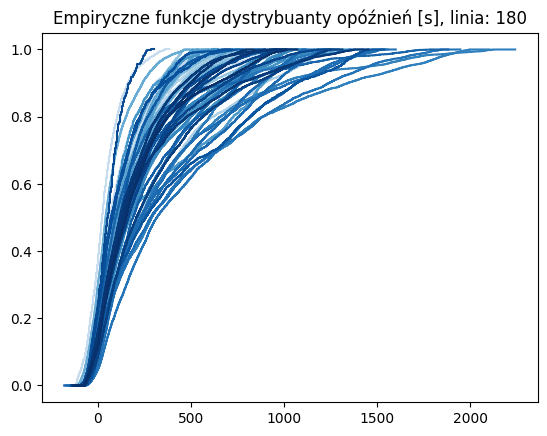

In [166]:
plot_ecdfs(dfs, "180")

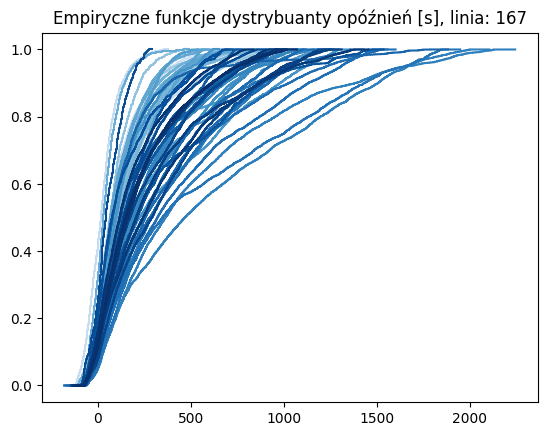

In [167]:
plot_ecdfs(dfs, "167")

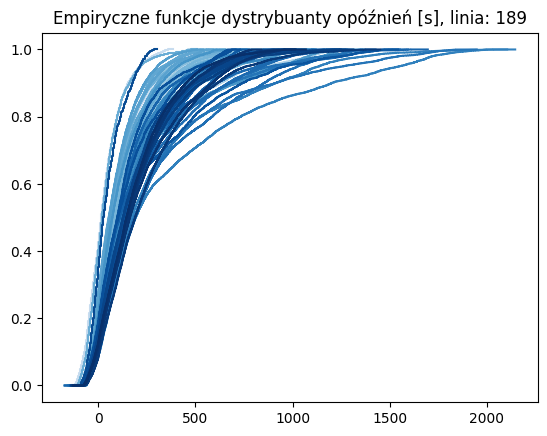

In [85]:
plot_ecdfs(dfs, "189")

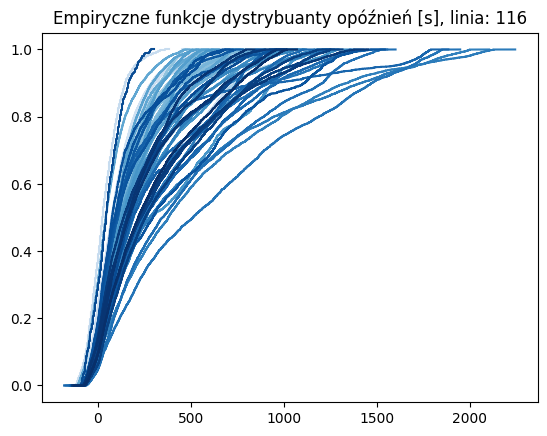

In [169]:
plot_ecdfs(dfs, "116")

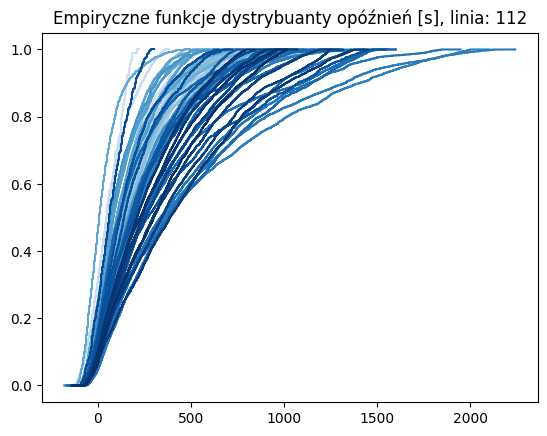

In [170]:
es = plot_ecdfs(dfs, "112")

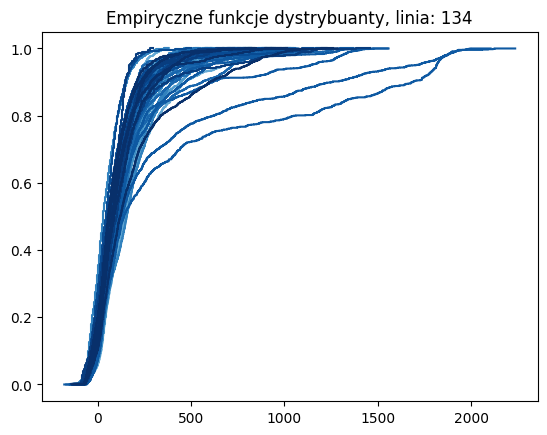

In [145]:
plot_ecdfs(dfs, "134")

### zbadanie linii 116 testem kolmogorova-smirnova

In [40]:
import itertools

In [87]:
fil = [("116" in x.route_short_name.unique()) for x in dfs]

In [88]:
dates_filtered = [i for (i, v) in zip(dates, fil) if v]

In [89]:
def ks_test(dfs, line):
    samples = []
    for df in dfs:
        sample = df.loc[df['route_short_name'] == line]['diff']
        if len(sample)==0: continue
        samples.append(sample)
    p_val = []
    ks_stat = []
    for i in range(len(samples)):
        l1 = np.array(list(itertools.chain(*samples[0:i])) + list(itertools.chain(*samples[i+1::])))
        l2 = np.array(list(samples[i]))
        res = stats.kstest(rvs = l1, cdf = l2)
        p_val.append(res.pvalue)
        ks_stat.append(res.statistic)
    ks_df = pd.DataFrame({"day": np.array(dates_filtered),"ksstat":np.array(ks_stat), "p-val":np.array(p_val)})
    return ks_df.sort_values(by="p-val", ascending=True)

In [90]:
ks_df = ks_test(dfs, "116")

In [ ]:
ks_df.sort_values(by="ksstat", ascending=False).head().set_index("day")

,ksstat,p-val
day,,
2022-03-31,0.250518,0.000000e+00
2022-12-15,0.194774,0.000000e+00
2022-03-30,0.186811,0.000000e+00
2022-04-19,0.162849,6.134435e-225
2022-06-16,0.162578,6.629241e-165


In [60]:
ks_df.sort_values(by="ksstat", ascending=False).tail().set_index("day")

,ksstat,p-val
day,,
2022-04-28,0.022583,0.000005
2023-05-30,0.021741,0.000010
2022-05-25,0.021350,0.000029
2022-04-20,0.012825,0.036629
2022-05-12,0.011151,0.085365


In [61]:
date_dict = dict(zip(dates, list(range(len(dates)))))

In [62]:
#plotowanie ecdf z podziałem na linie z danej daty
def plot_ecdfs_by_line(dfs, date, route_type):
    ecdfs = []
    for line in filter(lambda w: route_type_dict[w]==route_type, lista_linii) :
        df = dfs[date_dict[date]]
        sample = df.loc[df['route_short_name'] == line]['diff']
        if len(sample)==0: continue
        ecdfs.append(stats.ecdf(sample))
    i = 0
    for ecdf in ecdfs:
        ecdf.cdf.plot()
        i = i + 1
    plt.title(f'Empiryczne dystrybuanty opóźnień, podział na linie, data: {date}')
    plt.legend()

### dokładzniejszy wgląd w dane linii 116

In [81]:
# loading data
directory = "../data/gtfsy/"
date = "2022-12-15"

In [64]:
def load_gtfs(directory, date, file_type, rt):
    suffix = ""
    if rt: suffix = suffix + "-rt"
    return pd.read_csv(directory+date+suffix+".gtfs"+"/"+file_type+".txt")

In [82]:
stop_times_df = load_gtfs(directory, date, "stop_times", False)
rt_stop_times_df = load_gtfs(directory, date, "stop_times", True)
merged_df = stop_times_df.merge(rt_stop_times_df, on=['trip_id', 'stop_id'])

# Remove leading and trailing whitespaces using str.strip()
merged_df['departure_time_x'] = merged_df['departure_time_x'].str.strip()
merged_df['departure_time_y'] = merged_df['departure_time_y'].str.strip()

# Create the past_midnight column

merged_df['diff'] = pd.to_timedelta(merged_df['departure_time_y'], errors='coerce') - pd.to_timedelta(merged_df['departure_time_x'], errors='coerce')
merged_df['diff'] = merged_df['diff'].apply(lambda x: pd.Timedelta.total_seconds(x))
merged_df['stop_id'] = merged_df['stop_id'].str.strip()

trips_df = load_gtfs(directory, date, "trips", False)
routes_df = load_gtfs(directory, date, "routes", False)
merged_df_routes = merged_df.merge(trips_df, on=["trip_id"])
merged_df_routes = merged_df_routes.merge(routes_df, on=["route_id"])

In [190]:
df_116 = merged_df_routes.loc[merged_df_routes["route_short_name"]=="116"]
df_116["hour"] = df_116.arrival_time_x.str.slice(0,3)

In [191]:
df_116["hour"] = df_116.arrival_time_x.str.slice(0,3)

C:\Users\danie\AppData\Local\Temp\ipykernel_22116\1656411353.py:1: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_116["hour"] = df_116.arrival_time_x.str.slice(0,3)


In [224]:
df_116

,trip_id,arrival_time_x,departure_time_x,stop_id,stop_sequence_x,arrival_time_y,departure_time_y,stop_sequence_y,diff,route_id,service_id,wheelchair_accessible,agency_id,route_short_name,route_long_name,route_type,hour
65136,116_067_17_0914,09:14:00,09:14:00,3044_07,1,09:14:07,09:14:07,1,7.0,17,1,1,ZTM,116,Chomiczówka,3,09
65137,116_067_17_0914,09:16:00,09:16:00,3044_02,2,09:14:07,09:14:07,2,-113.0,17,1,1,ZTM,116,Chomiczówka,3,09
65138,116_067_17_0914,09:17:00,09:17:00,3043_02,3,09:15:52,09:15:58,3,-62.0,17,1,1,ZTM,116,Chomiczówka,3,09
65139,116_067_17_0914,09:19:00,09:19:00,3042_04,4,09:17:10,09:17:21,4,-99.0,17,1,1,ZTM,116,Chomiczówka,3,09
65140,116_067_17_0914,09:20:00,09:20:00,3036_02,5,09:17:48,09:17:56,5,-124.0,17,1,1,ZTM,116,Chomiczówka,3,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
73908,116_9_17_1944,20:44:00,20:44:00,6023_02,44,20:43:18,20:43:39,44,-21.0,17,1,1,ZTM,116,Chomiczówka,3,20
73909,116_9_17_1944,20:45:00,20:45:00,6024_02,45,20:44:26,20:44:51,45,-9.0,17,1,1,ZTM,116,Chomiczówka,3,20
73910,116_9_17_1944,20:46:00,20:46:00,6025_02,46,20:45:27,20:45:35,46,-25.0,17,1,1,ZTM,116,Chomiczówka,3,20
73911,116_9_17_1944,20:48:00,20:48:00,6026_05,47,20:48:26,20:48:26,47,26.0,17,1,1,ZTM,116,Chomiczówka,3,20


Text(0.5, 1.0, 'Średnie opóźnienia w trakcie trasy 19.04.2022')

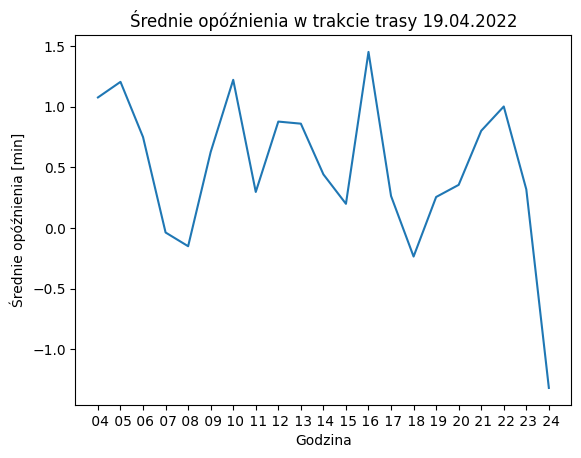

In [220]:
result = df_116.groupby(by=["hour"]).agg({'diff':'mean'})
result["diff"] = result["diff"]/60
plt.plot(result)
plt.ylabel("Średnie opóźnienia [min]")
plt.xlabel("Godzina")
plt.title("Średnie opóźnienia w trakcie trasy 19.04.2022")

In [207]:
df_116_2 = merged_df_routes.loc[merged_df_routes["route_short_name"]=="116"]
df_116_2["hour"] = df_116_2.arrival_time_x.str.slice(0,3)

C:\Users\danie\AppData\Local\Temp\ipykernel_22116\935166218.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_116_2["hour"] = df_116_2.arrival_time_x.str.slice(0,3)


Text(0.5, 1.0, 'Średnie opóźnienia w trakcie trasy 14.12.2022')

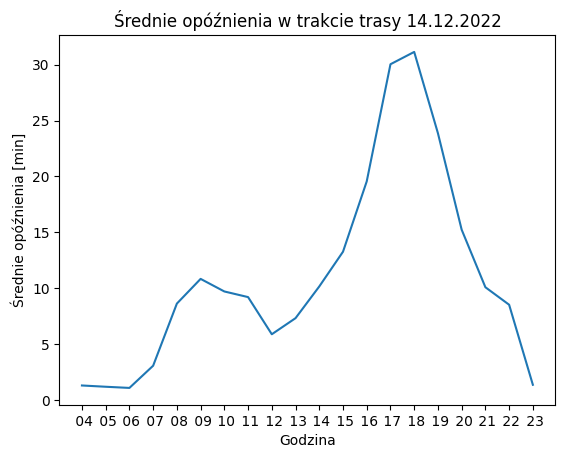

In [219]:
result = df_116_2.groupby(by=["hour"]).agg({'diff':'mean'})
result["diff"] = result["diff"]/60
plt.plot(result)
plt.ylabel("Średnie opóźnienia [min]")
plt.xlabel("Godzina")
plt.title("Średnie opóźnienia w trakcie trasy 14.12.2022")

In [211]:
df_116_3 = merged_df_routes.loc[merged_df_routes["route_short_name"]=="116"]
df_116_3["hour"] = df_116_3.arrival_time_x.str.slice(0,3)

C:\Users\danie\AppData\Local\Temp\ipykernel_22116\4186453393.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_116_3["hour"] = df_116_3.arrival_time_x.str.slice(0,3)


In [223]:
df_116_3

,trip_id,arrival_time_x,departure_time_x,stop_id,stop_sequence_x,arrival_time_y,departure_time_y,stop_sequence_y,diff,route_id,service_id,wheelchair_accessible,agency_id,route_short_name,route_long_name,route_type,hour
57167,116_067_15_0915,09:15:00,09:15:00,3044_07,1,09:16:04,09:16:04,1,64.0,15,1,1,ZTM,116,Chomiczówka,3,09
57168,116_067_15_0915,09:17:00,09:17:00,3044_02,2,09:16:04,09:16:22,2,-38.0,15,1,1,ZTM,116,Chomiczówka,3,09
57169,116_067_15_0915,09:18:00,09:18:00,3043_02,3,09:18:09,09:18:09,3,9.0,15,1,1,ZTM,116,Chomiczówka,3,09
57170,116_067_15_0915,09:20:00,09:20:00,3042_04,4,09:19:52,09:20:12,4,12.0,15,1,1,ZTM,116,Chomiczówka,3,09
57171,116_067_15_0915,09:22:00,09:22:00,3035_52,5,09:21:27,09:21:59,5,-1.0,15,1,1,ZTM,116,Chomiczówka,3,09
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
65741,116_9_15_1944,20:42:00,20:42:00,6022_02,42,20:45:12,20:45:46,42,226.0,15,1,1,ZTM,116,Chomiczówka,3,20
65742,116_9_15_1944,20:43:00,20:43:00,6023_02,43,20:46:52,20:47:01,43,241.0,15,1,1,ZTM,116,Chomiczówka,3,20
65743,116_9_15_1944,20:44:00,20:44:00,6024_02,44,20:47:45,20:47:57,44,237.0,15,1,1,ZTM,116,Chomiczówka,3,20
65744,116_9_15_1944,20:45:00,20:45:00,6025_02,45,20:48:57,20:48:57,45,237.0,15,1,1,ZTM,116,Chomiczówka,3,20


Text(0.5, 1.0, 'Średnie opóźnienia w trakcie trasy 06.06.2023')

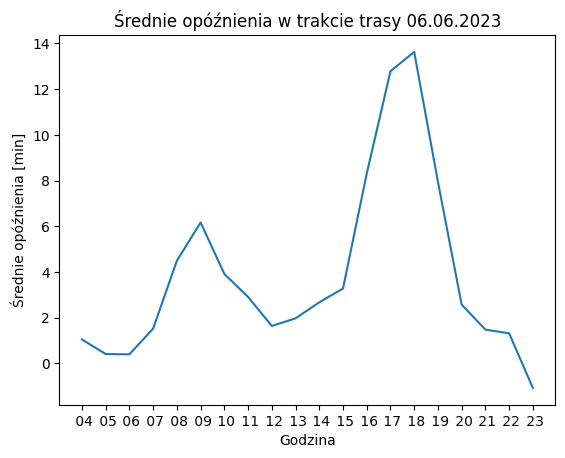

In [221]:
result = df_116_3.groupby(by=["hour"]).agg({'diff':'mean'})
result["diff"] = result["diff"]/60
plt.plot(result)
plt.ylabel("Średnie opóźnienia [min]")
plt.xlabel("Godzina")
plt.title("Średnie opóźnienia w trakcie trasy 06.06.2023")

In [217]:
df_116_4 = merged_df_routes.loc[merged_df_routes["route_short_name"]=="116"]
df_116_4["hour"] = df_116_4.arrival_time_x.str.slice(0,3)

C:\Users\danie\AppData\Local\Temp\ipykernel_22116\925532820.py:2: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df_116_4["hour"] = df_116_4.arrival_time_x.str.slice(0,3)


Text(0.5, 1.0, 'Średnie opóźnienia w trakcie trasy 04.20.2022')

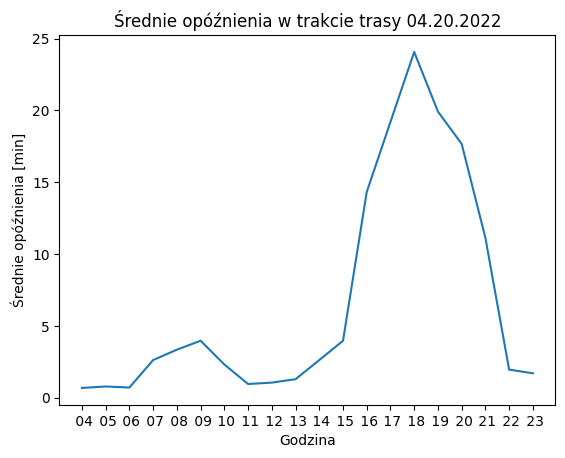

In [222]:
result = df_116_4.groupby(by=["hour"]).agg({'diff':'mean'})
result["diff"] = result["diff"]/60
plt.plot(result)
plt.ylabel("Średnie opóźnienia [min]")
plt.xlabel("Godzina")
plt.title("Średnie opóźnienia w trakcie trasy 04.20.2022")

### ploty ecdf z danej daty z podziałem na linie

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


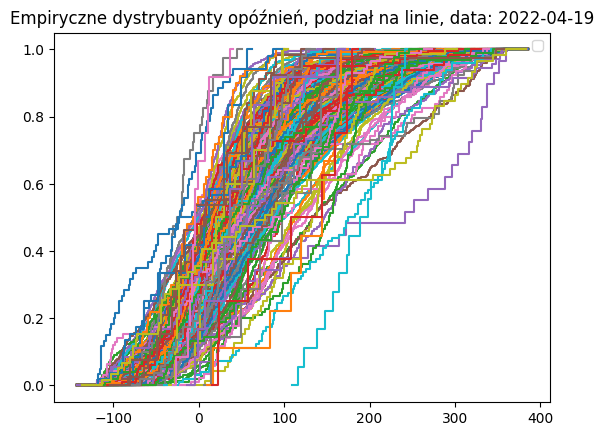

In [231]:
plot_ecdfs_by_line(dfs,"2022-04-19",3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


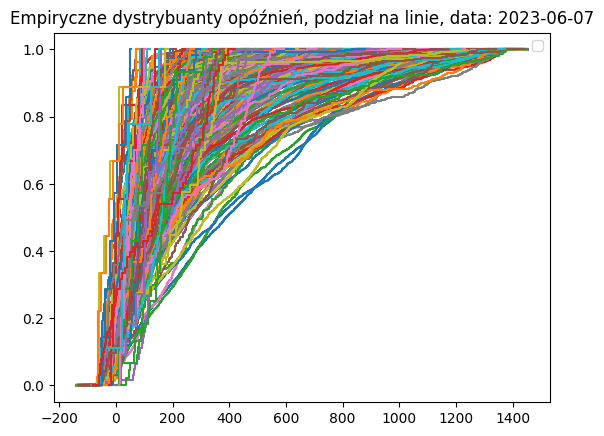

In [232]:
plot_ecdfs_by_line(dfs,"2023-06-07",3)

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


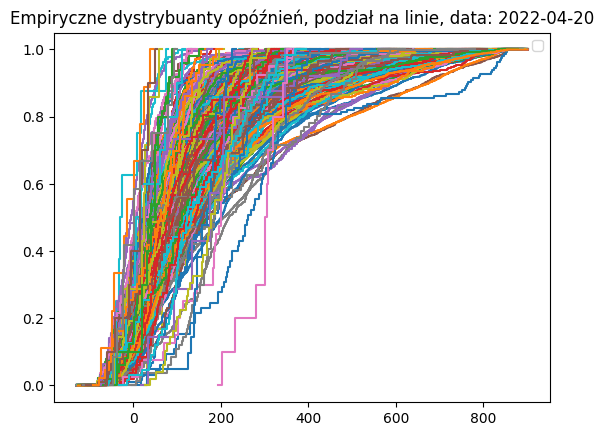

In [233]:
plot_ecdfs_by_line(dfs,"2022-04-20",3)